In [110]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import seaborn as sns
from nltk import WordNetLemmatizer

In [141]:
def cm_plot(y_test, y_pred, y_type):

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title(f'Confusion Matrix of {y_type}')

    return plt.show()

In [89]:
path = 'train_sent_emo.csv'
train = pd.read_csv(path)
path = 'test_sent_emo.csv'
test = pd.read_csv(path)
path = 'dev_sent_emo_replaced.csv'
dev = pd.read_csv(path)

Работа с SentiWordNet.txt

In [20]:
# f = open('SentiWordNet_3.0.0.txt', 'r')

In [21]:
# df = []
# df = pd.DataFrame(df)
# df.insert(0, 'POS', 'a')
# df.insert(1, 'ID', 0)
# df.insert(2, 'pos', 0)
# df.insert(3, 'neg', 0)
# df.insert(4, 'word', 'a')

In [2]:
# i = 0
# c = 0
# for line_ in f:
#     if line_[0]=='#':
#         continue
#     j = 0
#     k = 0
#     while j<=len(line_)-1:
#         print(i, j, k)
#         if j==0:
#             POS = line_[j]
#             if (i >=150000 and i<200000):
#                 df.loc[i, 'POS'] = line_[j]
#             j+=1
#             continue
#         elif line_[j]!=' ' and line_[j]!='\t':
#             word = ''
#             while(j<=len(line_)-1 and line_[j]!=' ' and line_[j]!='\t' ):
#                 word +=line_[j]
#                 j+=1
#             k+=1
#         if k == 1:
#             id = word
#             if (i >=150000 and i<200000):
#                 df.loc[i, 'ID'] = word
#             #k = 2
#             j+=1
#             continue
#         elif k ==2:
#             pos = word
#             if (i >=150000 and i<200000):
#                 df.loc[i, 'pos'] = word
#             #k = 3
#             j+=1
#             continue
#         elif k==3:
#             neg = word
#             if (i >=150000 and i<200000):
#                 df.loc[i, 'neg'] = word
#             #k = 4
#             j+=1
#             continue
#         elif k==4 and len(word)>3 and word[-2]=='#':
#             if (i >=150000 and i<200000):
#                 df.loc[i, 'word'] = word[:-2]
#             #k = 5
#             j+=1
#             continue
#         elif k==5 and len(word)>3 and word[-2]=='#':
#             i+=1
#             if (i >=150000 and i<200000):
#                 df.loc[i, 'POS'] = POS
#                 df.loc[i, 'ID'] = id
#                 df.loc[i, 'pos'] = pos
#                 df.loc[i, 'neg'] = neg
#                 df.loc[i, 'word'] = word[:-2]
#             j+=1
#             continue
#         else:
#             j+=1
#     i+=1
#     if(i >= 200000):
#         break

In [27]:
# df.tail(10)

,POS,ID,pos,neg,word
170922,v,02771320,0,0.25,blight
170923,v,02771564,0,0,swamp
170924,v,02771564,0,0,drench
170925,v,02771756,0,0,run_dry
170926,v,02771756,0,0,dry_out
170927,v,02771888,0,0.125,fog_up
170928,v,02771997,0,0,coal
170929,v,02771997,0,0,char
170930,v,02772202,0.125,0.25,haze
170931,v,02772310,0.125,0,deflagrate


In [26]:
# df = df.drop (index= 170932 )

In [28]:
# len(df)

20932

In [29]:
# df.to_csv('sentiwordnet170931.csv', index=False)

Работа с датафреймом по SentiWordNet

In [3]:
# s1 = pd.read_csv('sentiwordnet50000.csv')
# s2 = pd.read_csv('sentiwordnet100000.csv')
# s3 = pd.read_csv('sentiwordnet150000.csv')
# s4 = pd.read_csv('sentiwordnet170931.csv')

In [4]:
# swnDF = pd.concat([s1, s2, s3, s4], ignore_index=True)

In [5]:
# len(swnDF)

170932

In [6]:
# swnDF.to_csv('sentiwordnet.csv', index=False)

In [90]:
swnDF = pd.read_csv('sentiwordnet.csv')

In [8]:
swnDF.head(2)

,POS,ID,pos,neg,word
0,a,1740,0.125,0.00,able
1,a,2098,0.000,0.75,unable


In [91]:
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


def get_sentiment(word, tag, sentiwordnet):
    """ returns list of pos neg and objective score. But returns empty list if not present in senti wordnet. """
    wn_tag = penn_to_wn(tag)
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []
    lemmatizer = WordNetLemmatizer()
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    # if not lemma:
    #     return []
    pos_score = 0;
    neg_score = 0;
    num = 1
    for i in range(len(sentiwordnet)):
        if lemma == sentiwordnet.loc[i, 'word']:
            pos_score += sentiwordnet.loc[i, 'pos']
            neg_score += sentiwordnet.loc[i, 'neg']
            num += 1
    return [pos_score, neg_score, num]

In [95]:
i = 0
sentivectors = {}
for each in test.Utterance:
    #if (i > 8000):
    sentence = each
    token = nltk.word_tokenize(sentence)
    after_tagging = nltk.pos_tag(token)
        # print(i, ' ', after_tagging)
    senti_val = [get_sentiment(x, y, swnDF) for (x, y) in after_tagging]
    print(i)  #, ' ', senti_val)
    c = 0
    for m in senti_val:
        if m != []:
            if (c == 0):
                sentivectors[i] = {c: m}
            else:
                sentivectors[i][c] = m
            c += 1
    if (c == 0):
        sentivectors[i] = {0: [0, 0, 0]}
        # if (i == 8000):
        #     break
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [94]:
sentivectors[5]

{0: [0, 0, 1],
 1: [0.0, 2.25, 16],
 2: [0.625, 1.0, 15],
 3: [0.0, 2.25, 16],
 4: [0.25, 3.125, 14],
 5: [0.25, 3.125, 14]}

In [96]:
np.save('test', sentivectors)

In [97]:
def decoder_npy(path): #достает созданный выше словарь из файла
    data = np.load(path, allow_pickle=True)
    d = dict(enumerate(data.flatten(), 1))

    return d[1]

In [67]:
# d = dict(decoder_npy('train500.npy'))
# d2 = dict(decoder_npy('train1000.npy'))
# d3 = dict(decoder_npy('train1500.npy'))
# d4 = dict(decoder_npy('train2000.npy'))
# d5 = dict(decoder_npy('train2500.npy'))
# d6 = dict(decoder_npy('train3000.npy'))
# d7 = dict(decoder_npy('train4000.npy'))
# d8 = dict(decoder_npy('train5000.npy'))
# d9 = dict(decoder_npy('train6000.npy'))
# d10 = dict(decoder_npy('train7000.npy'))
# d11 = dict(decoder_npy('train8000.npy'))
# d12 = dict(decoder_npy('train8000+.npy'))

In [68]:
# d.update(d2)
# d.update(d3)
# d.update(d4)
# d.update(d5)
# d.update(d6)
# d.update(d7)
# d.update(d8)
# d.update(d9)
# d.update(d10)
# d.update(d11)
# d.update(d12)

In [70]:
# np.save('sentivectors', d)

Поработаем с векторами

In [71]:
d = decoder_npy('sentivectors.npy')

In [132]:
t = decoder_npy('test.npy')

In [ ]:
###  [max_pos, mean_pos,  max_neg, mean_neg, num_pos, num_neg, num_neut]

In [133]:
t_vecs = {}

In [134]:
for i in range(len(t)):
    max_pos = 0
    mean_pos = 0
    max_neg = 0
    mean_neg = 0
    num_pos = 0
    num_neg = 0
    num_neut = 0
    sum_pos = 0
    sum_neg = 0
    for key, each in t[i].items():
        if each[2] != 0:
            if each[0] > each[1]:
                num_pos += 1
            elif each[1] > each[0]:
                num_neg +=1
            else:
                num_neut +=1
            if max_pos < each[0]/each[2]:
                max_pos = each[0]/each[2]
            if max_neg < each[1]/each[2]:
                max_neg = each[1]/each[2]
            sum_pos += each[0]/each[2]
            sum_neg += each[1]/each[2]
    mean_pos = sum_pos/len(t[i])
    mean_neg = sum_neg/len(t[i])
    t_vecs[i] = [max_pos, mean_pos, max_neg, mean_neg, num_pos, num_neg, num_neut]

In [135]:
t_vecs[1]

[0.008928571428571428,
 0.0024659863945578234,
 0.044642857142857144,
 0.006377551020408163,
 1,
 1,
 5]

In [87]:
#np.save('sentivecs', d_vecs)

In [106]:
train_vecs = decoder_npy('sentivecs.npy')

In [104]:
train_df = []
train_df = pd.DataFrame(train_df)
train_df.insert(0, 'max_pos', -1)
train_df.insert(1, 'mean_pos', -1)
train_df.insert(2, 'max_neg', -1)
train_df.insert(3, 'mean_neg', -1)
train_df.insert(4, 'num_pos', -1)
train_df.insert(5, 'num_neg', -1)
train_df.insert(4, 'num_neut', -1)

In [107]:
for i in range(len(train_vecs)):
     train_df.loc[len(train_df.index)] = train_vecs[i]

In [108]:
train_df.head(2)

,max_pos,mean_pos,max_neg,mean_neg,num_neut,num_pos,num_neg
0,0.050000,0.009539,0.012500,0.001563,2.0,0.0,6.0
1,0.046875,0.040483,0.015625,0.013494,2.0,0.0,0.0


In [109]:
y_true = train.Emotion

In [112]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(max_iter=100000),
    #MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=100000),
    CatBoostClassifier(),
    LGBMClassifier(),
  #  XGBClassifier()
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, train_df, y_true, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Learning rate set to 0.087974
0:	learn: 1.8607829	total: 5.63ms	remaining: 5.63s
1:	learn: 1.7980015	total: 10.5ms	remaining: 5.25s
2:	learn: 1.7487625	total: 15.4ms	remaining: 5.11s
3:	learn: 1.7104604	total: 20ms	remaining: 4.97s
4:	learn: 1.6781246	total: 24.9ms	remaining: 4.95s
5:	learn: 1.6515148	total: 30.1ms	remaining: 4.98s
6:	learn: 1.6295317	total: 33.4ms	remaining: 4.74s
7:	learn: 1.6105324	total: 38.2ms	remaining: 4.74s
8:	learn: 1.5947594	total: 43.5ms	remaining: 4.79s
9:	learn: 1.5810947	total: 48ms	remaining: 4.76s
10:	learn: 1.5691720	total: 52.7ms	remaining: 4.74s
11:	learn: 1.5589613	total: 57.4ms	remaining: 4.73s
12:	learn: 1.5501241	total: 62.2ms	remaining: 4.72s
13:	learn: 1.5431251	total: 65.4ms	remaining: 4.61s
14:	learn: 1.5369353	total: 70.1ms	remaining: 4.6s
15:	learn: 1.5310201	total: 75.3ms	remaining: 4.63s
16:	learn: 1.5257429	total: 80.1ms	remaining: 4.63s
17:	learn: 1.5213770	total: 84.6ms	remaining: 4.61s
18:	learn: 1.5165792	total: 89.3ms	remaining: 4.6

In [113]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis=1,
                ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
CatBoostClassifier,0.463008,0.007033
LGBMClassifier,0.460006,0.006994
LinearSVC,0.471419,0.000270
LogisticRegression,0.471519,0.000835
RandomForestClassifier,0.474322,0.002485


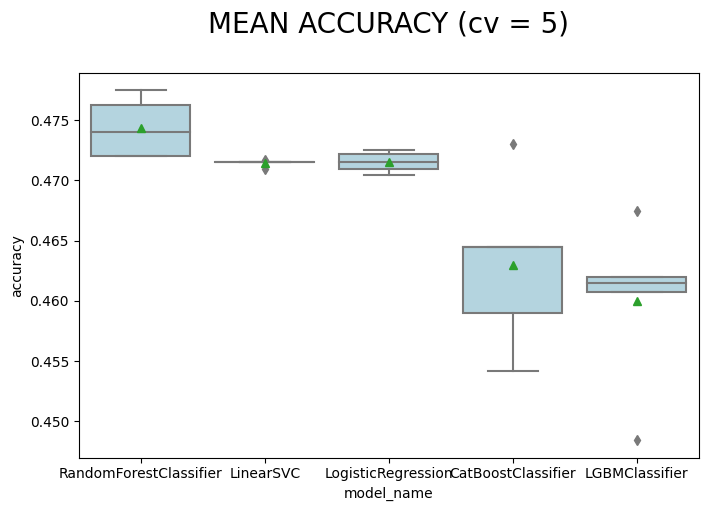

In [114]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=20);

In [145]:
# clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0).fit(train_df, y_true)
clf = LinearSVC(random_state=x, max_iter=100000, class_weight='balanced').fit(train_df, y_true)

In [136]:
test_df = []
test_df = pd.DataFrame(test_df)
test_df.insert(0, 'max_pos', -1)
test_df.insert(1, 'mean_pos', -1)
test_df.insert(2, 'max_neg', -1)
test_df.insert(3, 'mean_neg', -1)
test_df.insert(4, 'num_pos', -1)
test_df.insert(5, 'num_neg', -1)
test_df.insert(4, 'num_neut', -1)

In [149]:
test_df.to_csv('test_sentivecs.csv', index=False)
train_df.to_csv('train_sentivecs.csv', index=False)

In [137]:
for i in range(len(t_vecs)):
     test_df.loc[len(test_df.index)] = t_vecs[i]

In [146]:
y_pred = clf.predict(test_df)

In [139]:
y_test_true = test.Emotion

In [140]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test_true, y_pred)) #RF

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       345
     disgust       0.00      0.00      0.00        68
        fear       0.00      0.00      0.00        50
         joy       0.42      0.01      0.02       402
     neutral       0.49      0.99      0.65      1256
     sadness       0.41      0.08      0.14       208
    surprise       0.00      0.00      0.00       281

    accuracy                           0.48      2610
   macro avg       0.19      0.15      0.12      2610
weighted avg       0.33      0.48      0.33      2610



C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [147]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test_true, y_pred)) #SVC

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

       anger       0.50      0.01      0.01       345
     disgust       0.03      0.01      0.02        68
        fear       0.00      0.00      0.00        50
         joy       0.27      0.11      0.15       402
     neutral       0.50      0.77      0.60      1256
     sadness       0.16      0.33      0.21       208
    surprise       0.00      0.00      0.00       281

    accuracy                           0.41      2610
   macro avg       0.21      0.18      0.14      2610
weighted avg       0.36      0.41      0.33      2610



C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

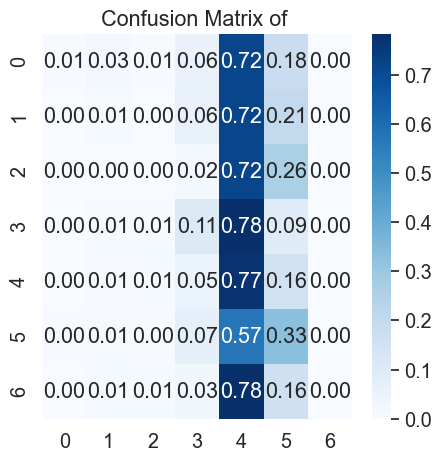

In [148]:
cm_plot(y_test_true, y_pred, '') # SVC

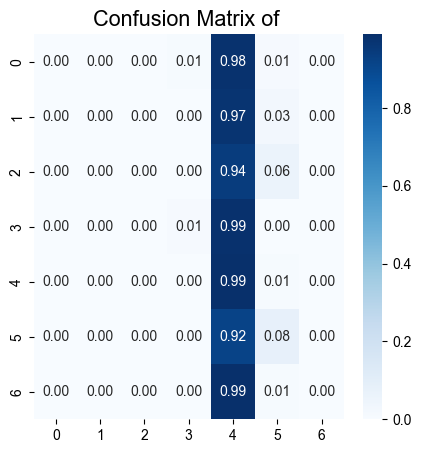

In [144]:
cm_plot(y_test_true, y_pred, '')